In [1]:
import pickle
import os
import gc
import numpy as np
from sklearn.cluster import KMeans, Birch
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import math
from sklearn.metrics import homogeneity_score
from scipy.stats import entropy
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse
from sklearn.cluster import DBSCAN
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.cluster import KMeans
from collections import defaultdict
from matplotlib.animation import FuncAnimation
from scipy.stats import kruskal
from scipy.stats import f_oneway, kruskal
from fairis_tools.experiment_tools.place_cell.PlaceCellLibrary import *

In [2]:
os.chdir("../../..")
print(os.getcwd())

/Users/titonka/FAIRIS


In [4]:
with open("data/VisualPlaceCellData/VisualPlaceCellClusters/multimodal_kmeans_100_LM8",'rb') as file:
    data = pickle.load(file)

In [5]:
pc_network = VisualPlaceCellNetwork()
for cluster in data:
    pc_network.add_pc_to_network(cluster[0],radius=cluster[1])

del data
gc.collect()

308

In [6]:
with open("data/VisualPlaceCellData/LM8_Testing",'rb') as file:
    test_data = pickle.load(file)

In [7]:
landmarks = [
    (1.85, 1.85, (1.00, 0.00, 0.00)),
    (0.00, 2.61, (0.00, 1.00, 0.00)),
    (-1.85, 1.85, (0.00, 0.00, 1.00)),
    (-2.61, 0.00, (1.00, 1.00, 0.00)),
    (-2.61, 0.00, (1.00, 0.00, 1.00)),
    (-1.85, -1.85, (0.00, 1.00, 1.00)),
    (0.00, -2.61, (1.00, 0.50, 0.00)),
    (1.85, -1.85, (0.50, 0.00, 0.50)),
    (2.61, 0.00, (0.50, 0.50, 0.00))
]


In [16]:
def plot_place_cell_activity(index, landmarks=None, pc_sample_size=25):
    """
    Plot the x, y, θ position and a sample of place cell activations for a given data point.

    Args:
    - index (int): The index of the selected data point.
    - landmarks (list): List of tuples (x, y, (r, g, b)) representing landmark positions and colors.
    - pc_sample_size (int): Total number of place cells to display, including max and min activated ones.
    """
    obs = test_data.observations[index]
    x, y = obs.x, obs.y
    dx = 0.45 * np.cos(obs.theta)
    dy = 0.45 * np.sin(obs.theta)

    # Fetch PC activations
    activations = pc_network.get_all_pc_activations_normalized(
        obs.multimodal_feature_vector, norm_type='min_max'
    )

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # --- Subplot 1: Spatial orientation and landmarks ---
    ax[0].quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].scatter(x, y, color='blue', s=50, zorder=5)
    ax[0].set_xlim(-3.5, 3.5)
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].set_title("x, y, θ of New Data Point")
    ax[0].set_xlabel("X Coordinate")
    ax[0].set_ylabel("Y Coordinate")

    if landmarks:
        landmark_positions = [(lx, ly) for (lx, ly, _) in landmarks]
        landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))
        for lx, ly, color in landmarks:
            ax[0].scatter(lx, ly, color=color, s=80, edgecolor='black', zorder=10)
        for i in range(len(landmark_positions)):
            x1, y1 = landmark_positions[i]
            x2, y2 = landmark_positions[(i + 1) % len(landmark_positions)]
            ax[0].plot([x1, x2], [y1, y2], color='black', linewidth=1)

    # --- Subplot 2: Sample PC Activations ---
    n_pcs = len(activations)
    all_indices = list(range(n_pcs))
    max_index = int(np.argmax(activations))
    min_index = int(np.argmin(activations))

    remaining_indices = list(set(all_indices) - {max_index, min_index})
    sampled_indices = random.sample(remaining_indices, pc_sample_size - 2)
    selected_indices = [min_index, max_index] + sampled_indices
    selected_activations = [activations[i] for i in selected_indices]

    display_labels = [f"PC {i+1}" for i in range(pc_sample_size)]

    ax[1].bar(range(pc_sample_size), selected_activations, color='red')
    ax[1].set_title("VPCE Activation Pattern for New Data Point")
    ax[1].set_xlabel("Place Cell")
    ax[1].set_ylabel("Activation Level")
    ax[1].set_xticks(range(pc_sample_size))
    ax[1].set_xticklabels(display_labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

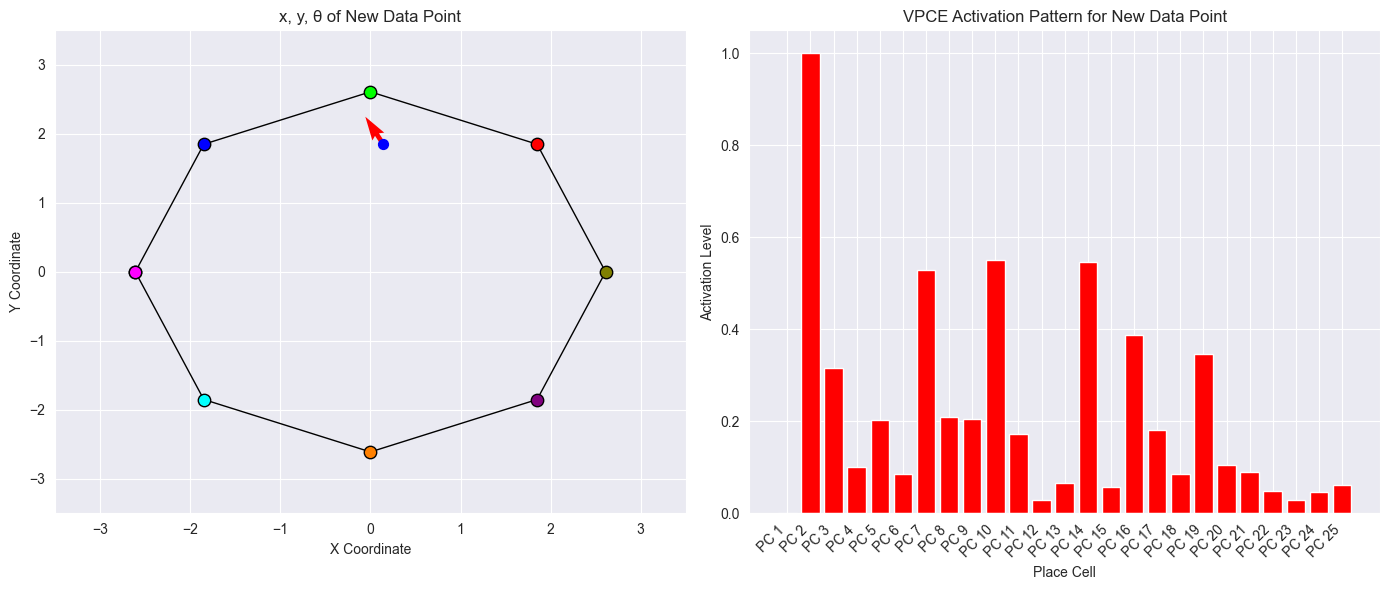

In [35]:
plot_place_cell_activity(10,landmarks=landmarks)

# Segmentation of the testing set and grouping by spatial location

In [11]:
def group_dataset_by_theta_and_spatial_proximity(dataset, n_clusters=3):
    """
    Groups observations in the dataset by unique theta values and further clusters
    each group based on spatial proximity (x, y coordinates) using k-means clustering.

    Parameters:
    - dataset: An object with an 'observations' attribute, which is a list of observations.
               Each observation should have 'theta', 'x', and 'y' attributes.
    - n_clusters: The number of clusters to form within each theta group (k for k-means).

    Returns:
    - dict: A nested dictionary where the first-level keys are unique theta values,
            and the second-level keys are cluster labels. The values are lists of observations.
    """
    # Initialize a dictionary to hold the grouped data
    grouped_data = defaultdict(lambda: defaultdict(list))

    # First round of grouping by unique theta values
    theta_groups = defaultdict(list)
    for observation in dataset.observations:
        theta_groups[observation.theta].append(observation)

    # Second round of grouping based on spatial proximity within each theta group
    for theta, observations in theta_groups.items():
        # Extract x and y coordinates
        coords = np.array([(obs.x, obs.y) for obs in observations])

        # Apply k-means clustering
        if len(observations) >= n_clusters:
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)
            labels = kmeans.labels_
        else:
            # If the number of observations is less than the number of clusters,
            # assign all observations to a single cluster labeled as 0
            labels = np.zeros(len(observations), dtype=int)

        # Group observations by cluster labels
        for label, obs in zip(labels, observations):
            grouped_data[theta][label].append(obs)

    return grouped_data

In [12]:
def plot_clusters_with_vectors(grouped_data):
    """
    Plots subplots for each theta group, displaying clusters with color and marker variations.
    Each data point is represented with a vector indicating its direction based on theta.

    Parameters:
    - grouped_data: A nested dictionary where the first-level keys are unique theta values,
                    and the second-level keys are cluster labels. The values are lists of
                    observations, each having 'x', 'y', and 'theta' attributes.
    """
    # Define a list of marker styles for differentiation
    markers = ['o', 's', 'v', '^', '<', '>', 'p', '*', 'h', 'H', 'D', 'd']
    
    # Get the 'tab10' colormap
    cmap = plt.get_cmap('tab10')
    
    # Determine the number of unique theta groups
    num_theta_groups = len(grouped_data)
    
    # Set up a 2x4 grid for subplots
    num_rows = 2
    num_cols = 4

    # Create subplots with shared x and y axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 10), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    # Iterate over each theta group
    for ax, (theta, clusters) in zip(axes, grouped_data.items()):
        ax.set_title(f'Theta = {theta}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_box_aspect(1)  # Ensure the subplot is square

        # Iterate over each cluster within the theta group
        for cluster_idx, (cluster_label, observations) in enumerate(clusters.items()):
            # Extract x, y, and theta values
            x_vals = [obs.x for obs in observations]
            y_vals = [obs.y for obs in observations]
            theta_vals = [obs.theta for obs in observations]

            # Select marker and color for the cluster
            marker = markers[cluster_idx % len(markers)]
            color = cmap(cluster_idx % cmap.N)

            # Plot data points
            ax.scatter(x_vals, y_vals, label=f'Cluster {cluster_label}', marker=marker, color=color, alpha=0.6)

            # Plot vectors indicating direction based on theta
            for x, y, theta in zip(x_vals, y_vals, theta_vals):
                dx = np.cos(math.radians(theta))  # Change in x
                dy = np.sin(math.radians(theta))  # Change in y
                # ax.arrow(x, y, dx, dy, head_width=0.05, head_length=0.01, fc=color, ec=color, alpha=0.6)

        # Position the legend outside the plot
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Hide any unused subplots
    for i in range(len(grouped_data), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [6]:
spatial_grouped = group_dataset_by_theta_and_spatial_proximity(test_data,n_clusters=25)

In [ ]:
for key1 in spatial_grouped.keys():
    print("Grouping for Theta: ", key1)
    for key2 in spatial_grouped[key1].keys():
        print("Key " + str(key2) + " : Number " + str(len(spatial_grouped[key1][key2])))

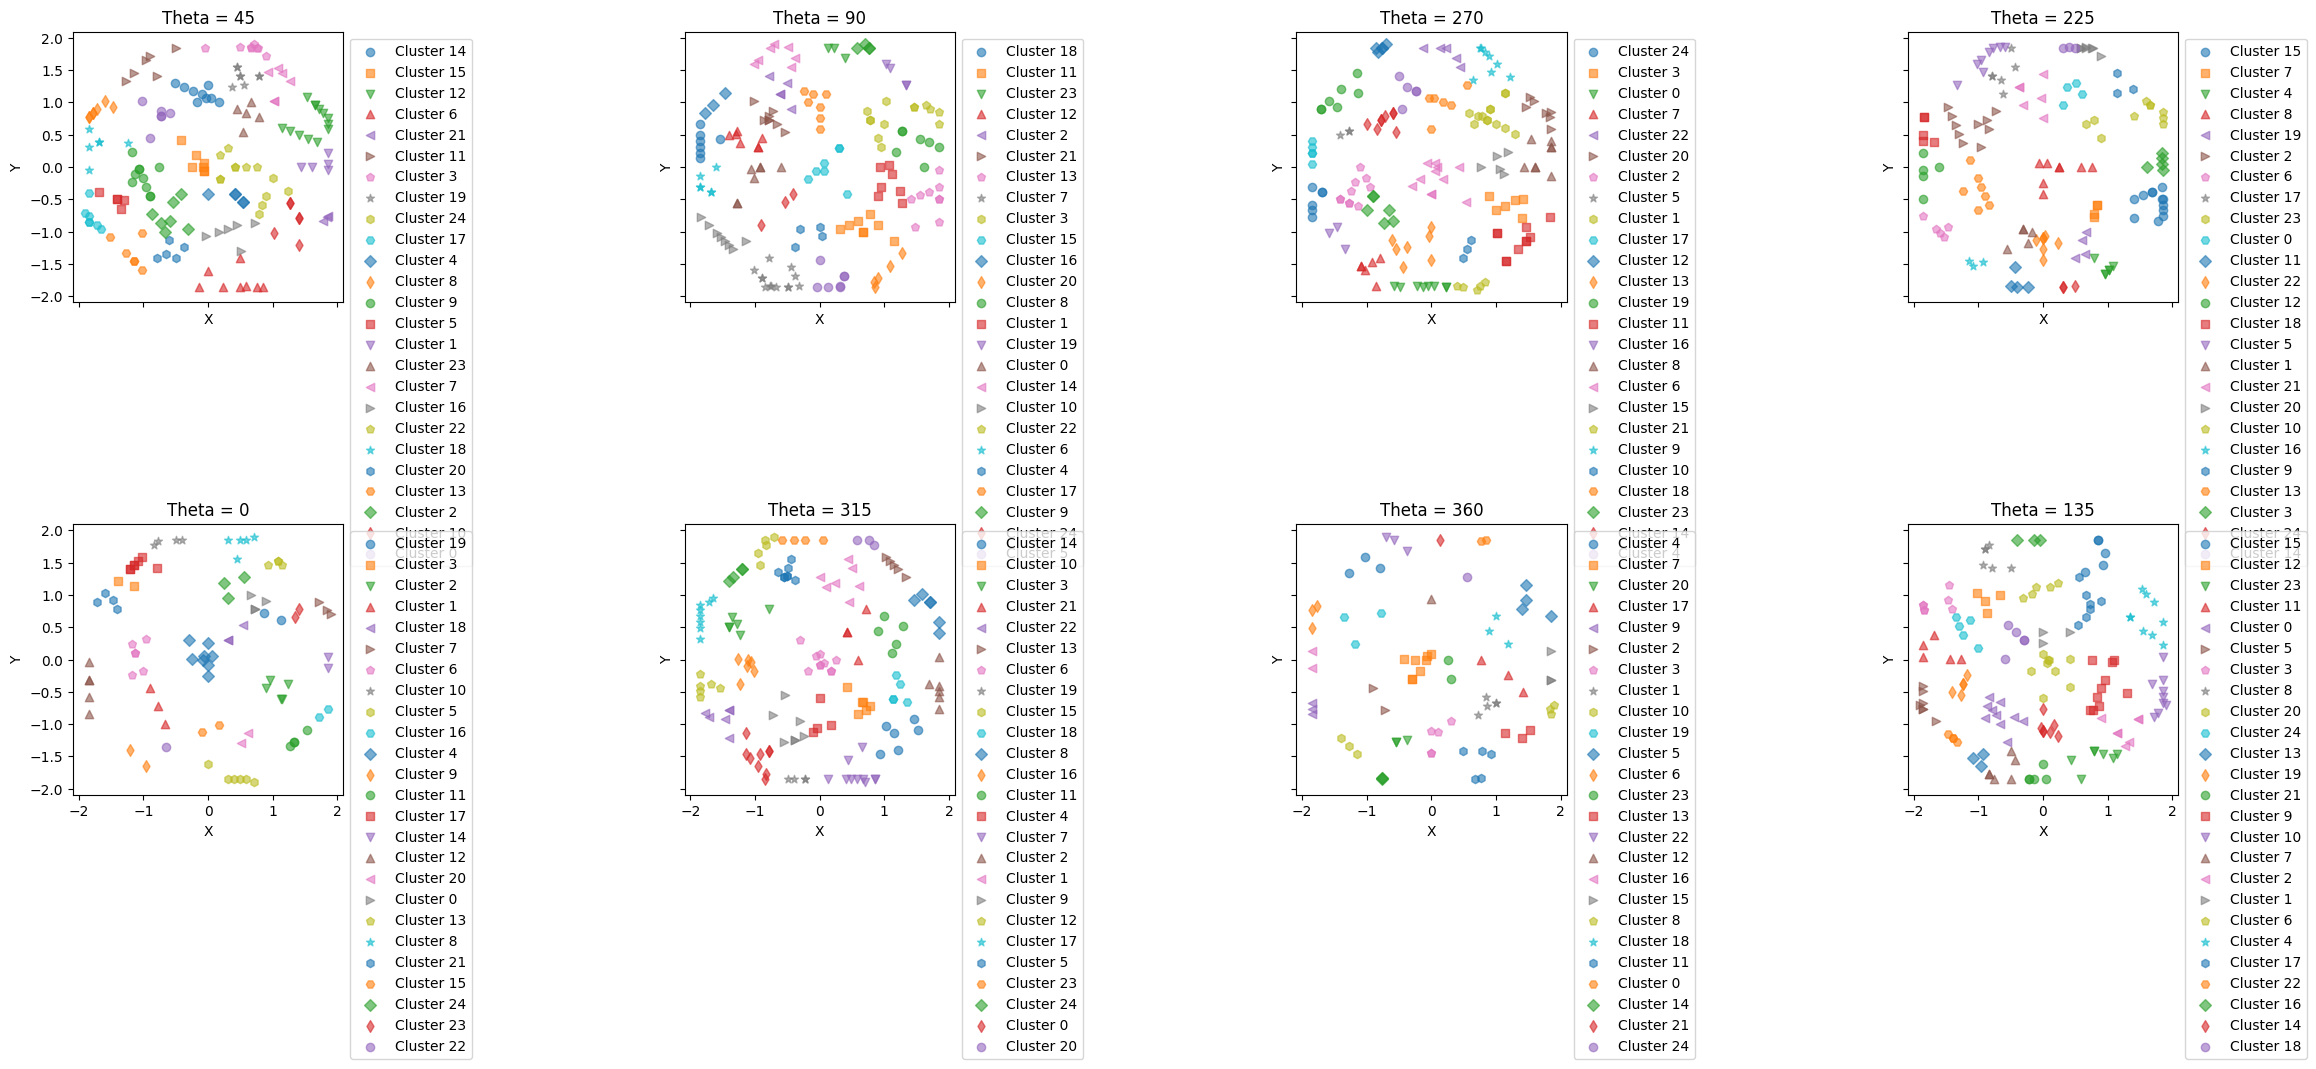

In [21]:
plot_clusters_with_vectors(spatial_grouped)

In [13]:
def calculate_and_visualize_similarity_with_scaling(grouped_data, pc_network, feature_type="cnn", normalization_method="min-max"):
    """
    Calculate and visualize similarity metrics for place cell activations within each spatial cluster,
    applying the specified normalization method.

    Parameters:
    - grouped_data: dict, nested dictionary with structure {theta: {cluster_label: [data_points]}}
    - pc_network: object, the place cell network used to get activations.
    - feature_type: str, type of feature vector ("cnn" or other).
    - normalization_method: str, normalization method to apply ("min-max" or "unit-vector").

    Returns:
    - summary_df: DataFrame summarizing the average similarity metrics for each theta and cluster.
    """
    summary_records = []

    for theta, clusters in grouped_data.items():
        for cluster_label, data_points in clusters.items():
            # Extract activation vectors for the data points in the current cluster
            activation_vectors = []
            for dp in data_points:
                if feature_type == "cnn":
                    activations = pc_network.get_all_pc_activations_normalized(dp.cnn_feature_vector)
                else:
                    activations = pc_network.get_all_pc_activations_normalized(dp.multimodal_feature_vector)
                activation_vectors.append(activations)

            # Convert to numpy array for easier computation
            activation_vectors = np.array(activation_vectors)

            # Apply the selected normalization method
            if normalization_method == "min-max":
                scaler = MinMaxScaler()
                activation_vectors = scaler.fit_transform(activation_vectors)
            elif normalization_method == "unit-vector":
                norms = np.linalg.norm(activation_vectors, axis=1, keepdims=True)
                activation_vectors = activation_vectors / norms
            else:
                raise ValueError("Unsupported normalization method. Choose 'min-max' or 'unit-vector'.")

            # Calculate pairwise Cosine Similarity
            cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))

            # Calculate pairwise Euclidean Distance
            euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))

            # Calculate pairwise Pearson Correlation Coefficient
            num_vectors = len(activation_vectors)
            pearson_corr_matrix = np.zeros((num_vectors, num_vectors))
            for i in range(num_vectors):
                for j in range(num_vectors):
                    if i != j:
                        pearson_corr, _ = pearsonr(activation_vectors[i], activation_vectors[j])
                        pearson_corr_matrix[i, j] = pearson_corr
                    else:
                        pearson_corr_matrix[i, j] = 1  # Correlation with itself

            # Visualize the similarity matrices using heatmaps
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            sns.heatmap(cosine_sim_matrix, ax=axes[0], annot=True, cmap='viridis')
            axes[0].set_title(f'Cosine Similarity\nTheta: {theta}, Cluster: {cluster_label}')
            axes[0].set_xlabel('Data Point Index')
            axes[0].set_ylabel('Data Point Index')

            sns.heatmap(pearson_corr_matrix, ax=axes[1], annot=True, cmap='viridis')
            axes[1].set_title(f'Pearson Correlation\nTheta: {theta}, Cluster: {cluster_label}')
            axes[1].set_xlabel('Data Point Index')
            axes[1].set_ylabel('Data Point Index')

            sns.heatmap(euclidean_dist_matrix, ax=axes[2], annot=True, cmap='viridis')
            axes[2].set_title(f'Euclidean Distance\nTheta: {theta}, Cluster: {cluster_label}')
            axes[2].set_xlabel('Data Point Index')
            axes[2].set_ylabel('Data Point Index')

            plt.tight_layout()
            plt.show()

            # Compute average metrics for the current cluster
            avg_cosine_sim = np.mean(cosine_sim_matrix[np.triu_indices(num_vectors, k=1)])
            avg_pearson_corr = np.mean(pearson_corr_matrix[np.triu_indices(num_vectors, k=1)])
            avg_euclidean_dist = np.mean(euclidean_dist_matrix[np.triu_indices(num_vectors, k=1)])

            # Append the results to the summary records
            summary_records.append({
                'Theta': theta,
                'Cluster': cluster_label,
                'Avg Cosine Similarity': avg_cosine_sim,
                'Avg Pearson Correlation': avg_pearson_corr,
                'Avg Euclidean Distance': avg_euclidean_dist
            })

    # Create a DataFrame to summarize the results
    summary_df = pd.DataFrame(summary_records)
    return summary_df

In [ ]:
summary_df = calculate_and_visualize_similarity_with_scaling(spatial_grouped, pc_network, feature_type="multimodal")
print(summary_df)

In [ ]:
summary_df = calculate_and_visualize_similarity_with_scaling(spatial_grouped, pc_network, feature_type="multimodal",normalization_method="unit-vector")
print(summary_df)

# Segment Testing data by orientation only, Then use random selection to get groups using knn. 

In [14]:
def group_dataset_by_theta(dataset):
    """
    Groups observations in the dataset by unique theta values. This function
    does not consider spatial proximity (x, y coordinates) during grouping.

    Parameters:
    - dataset: An object with an 'observations' attribute, which is a list of observations.
               Each observation is expected to have a 'theta' attribute.

    Returns:
    - dict: A dictionary where the keys are unique theta values, and the values are
            lists of observations corresponding to each theta.
    """
    # Initialize a dictionary to store the grouped observations by theta
    theta_groups = defaultdict(list)

    # Iterate through the observations and group them by their theta value
    for observation in dataset.observations:
        theta_groups[observation.theta].append(observation)

    return theta_groups

In [15]:
def select_knn_with_orientation(grouped_data, orientation, k, mode='nearest_same_orientation'):
    """
    Selects k data points based on spatial proximity and orientation.

    Parameters:
    - grouped_data: dict, output of group_dataset_by_theta function {theta: [data_points]}.
    - orientation: float, the orientation (theta) to select the initial data point from.
    - k: int, the number of neighbors to select.
    - mode: str, selection mode ('nearest_same_orientation', 'farthest_same_orientation', 
             'farthest_different_orientation', 'nearest_different_orientation').

    Returns:
    - list: A list containing k selected data points based on the chosen mode.
    """
    if mode not in ['nearest_same_orientation', 'farthest_same_orientation', 
                    'farthest_different_orientation', 'nearest_different_orientation']:
        raise ValueError("Invalid mode. Choose from 'nearest_same_orientation', 'farthest_same_orientation', "
                         "'farthest_different_orientation', or 'nearest_different_orientation'.")

    if mode == 'nearest_same_orientation':
        # Get all points with the same orientation
        if orientation not in grouped_data or len(grouped_data[orientation]) == 0:
            raise ValueError(f"No data points available for the specified orientation: {orientation}")

        data_points = grouped_data[orientation]
        
        # Randomly select an initial data point
        selected_point = random.choice(data_points)
        selected_point_coords = np.array([selected_point.x, selected_point.y])

        # Find the k nearest neighbors
        distances = cdist([selected_point_coords], [(dp.x, dp.y) for dp in data_points])[0]
        nearest_indices = np.argsort(distances)[:k + 1]  # +1 to include the selected point

        # Return the initial point and k nearest neighbors
        return [data_points[i] for i in nearest_indices if data_points[i] != selected_point][:k]

    if mode == 'nearest_different_orientation':
        # Get all points with different orientations
        candidate_points = [dp for theta, points in grouped_data.items() if theta != orientation for dp in points]
        if len(candidate_points) == 0:
            raise ValueError("No data points available with different orientations.")

        # Randomly select an initial data point
        selected_point = random.choice(candidate_points)
        selected_point_coords = np.array([selected_point.x, selected_point.y])

        # Compute distances to all candidates
        distances = cdist([selected_point_coords], [(dp.x, dp.y) for dp in candidate_points])[0]
        nearest_indices = np.argsort(distances)[:k]  # Select k nearest neighbors

        return [candidate_points[i] for i in nearest_indices]

    if mode in ['farthest_same_orientation', 'farthest_different_orientation']:
        if mode == 'farthest_same_orientation':
            if orientation not in grouped_data or len(grouped_data[orientation]) == 0:
                raise ValueError(f"No data points available for the specified orientation: {orientation}")
            candidate_points = grouped_data[orientation]
        else:
            # Different orientation points
            candidate_points = [dp for theta, points in grouped_data.items() if theta != orientation for dp in points]
            if len(candidate_points) == 0:
                raise ValueError("No data points available with different orientations.")

        # Step 3: Convert points to (x, y) coordinates
        candidate_coords = np.array([(dp.x, dp.y) for dp in candidate_points])

        # Step 4: Greedy selection of k points that maximize pairwise distances
        # Randomly select the first point
        selected_indices = [random.randint(0, len(candidate_coords) - 1)]
        selected_points = [candidate_points[selected_indices[0]]]

        while len(selected_indices) < k:
            # Calculate distances from the current set of selected points to all candidates
            distances_to_selected = np.min(cdist(candidate_coords, candidate_coords[selected_indices]), axis=1)

            # Exclude already selected points
            distances_to_selected[selected_indices] = -np.inf

            # Select the point with the maximum distance to the current selection
            next_index = np.argmax(distances_to_selected)
            selected_indices.append(next_index)
            selected_points.append(candidate_points[next_index])

        return selected_points


In [16]:
def calculate_and_visualize_similarity(data_points, pc_network, feature_type='multimodal', landmarks=None):
    """
    Calculate and visualize similarity metrics for a list of grouped data points.
    Includes spatial plots with landmarks, similarity heatmaps, and bar graphs of place cell activations.

    Parameters:
    - data_points: list of data points where each point contains attributes 'x', 'y', 'theta',
                   and feature vectors ('cnn_feature_vector', 'multimodal_feature_vector').
    - pc_network: object, the place cell network used to get activations.
    - feature_type: str, the feature type used to calculate activations ('cnn' or 'multimodal').
    - landmarks: list of tuples [(x, y, (r, g, b))], coordinates and colors of landmarks.

    Returns:
    - None, but displays the combined visualization.
    """
    # Determine the layout of subplots (square layout)
    num_points = len(data_points)
    num_cols = math.ceil(math.sqrt(num_points + 4))  # +4 to account for 3 heatmaps + spatial plot
    num_rows = num_cols  # Ensure a square layout

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()

    # First plot: spatial layout (x, y) with orientation vector
    spatial_ax = axes[0]
    x_coords = [dp.x for dp in data_points]
    y_coords = [dp.y for dp in data_points]
    thetas = [dp.theta for dp in data_points]

    # Build the octagon using landmark positions if provided
    if landmarks is not None:
        landmark_positions = [(x, y) for (x, y, _) in landmarks]

        # Sort landmarks based on their angle from the origin to create an ordered octagon
        landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))
        octagon_vertices = np.array(landmark_positions + [landmark_positions[0]])  # Close the octagon

        # Plot the octagon
        spatial_ax.plot(octagon_vertices[:, 0], octagon_vertices[:, 1], color='black', linewidth=2)

        # Plot landmarks
        for (x, y, (r, g, b)) in landmarks:
            spatial_ax.scatter(x, y, color=(r, g, b), s=100)

    # Plot data points and their orientations using arrows
    spatial_ax.scatter(x_coords, y_coords, c='blue')
    for x, y, theta_deg in zip(x_coords, y_coords, thetas):
        theta_rad = np.deg2rad(theta_deg)
        dx = 0.5 * np.cos(theta_rad)
        dy = 0.5 * np.sin(theta_rad)
        spatial_ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Set axis limits and labels
    spatial_ax.set_xlim([-2.7, 2.7])
    spatial_ax.set_ylim([-2.7, 2.7])
    spatial_ax.set_title('Spatial Layout with Orientation')
    spatial_ax.set_xlabel('X')
    spatial_ax.set_ylabel('Y')

    # Store all activation vectors for similarity calculations
    activation_vectors = []

    # Generate activations for similarity metrics
    for dp in data_points:
        if feature_type == 'cnn':
            activations = pc_network.get_all_pc_activations_normalized(dp.cnn_feature_vector, norm_type='min_max')
        else:
            activations = pc_network.get_all_pc_activations_normalized(dp.multimodal_feature_vector, norm_type='min_max')
        activation_vectors.append(activations)

    # Convert activation vectors to NumPy array for pairwise comparisons
    activation_vectors = np.array(activation_vectors)

    # Calculate similarity metrics
    cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
    euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
    n = len(pc_network.pc_list)
    euclidean_scale = np.sqrt(n)

    # Pearson correlation matrix
    num_vectors = len(activation_vectors)
    pearson_corr_matrix = np.zeros((num_vectors, num_vectors))
    for i in range(num_vectors):
        for j in range(num_vectors):
            if i != j:
                pearson_corr, _ = pearsonr(activation_vectors[i], activation_vectors[j])
                pearson_corr_matrix[i, j] = pearson_corr
            else:
                pearson_corr_matrix[i, j] = 1  # Correlation with itself

    # Heatmaps for similarity metrics
    heatmap_titles = ['Cosine Similarity', 'Pearson Correlation', 'Euclidean Distance']
    similarity_matrices = [cosine_sim_matrix, pearson_corr_matrix, euclidean_dist_matrix]
    heatmap_scales = [(0, 1), (0, 1), (0, euclidean_scale)]  # Scales for each heatmap

    # Plot heatmaps right after the spatial layout
    for idx, (matrix, title, scale) in enumerate(zip(similarity_matrices, heatmap_titles, heatmap_scales)):
        ax = axes[idx + 1]  # Place heatmaps after spatial plot
        sns.heatmap(matrix, ax=ax, annot=True, cmap='viridis', vmin=scale[0], vmax=scale[1])
        ax.set_title(title)
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Data Point Index')

    # Generate bar plots of place cell activations after heatmaps
    for i, dp in enumerate(data_points):
        ax = axes[len(similarity_matrices) + i + 1]  # Start after heatmaps
        activations = activation_vectors[i]
        ax.bar(range(len(activations)), activations, color='orange')
        ax.set_title(f'PC Activations (Data Point {i + 1})')
        ax.set_xlabel('Place Cell Index')
        ax.set_ylabel('Activation')

    # Hide any unused subplots
    for j in range(len(similarity_matrices) + len(data_points) + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [17]:
def calculate_similarity_metrics(grouped_data, pc_network, n=20, mode='nearest_same_orientation', feature_type='multimodal'):
    """
    Calculate similarity metrics by repeatedly grouping data points using the specified mode.
    
    Parameters:
    - grouped_data: dict, output of group_dataset_by_theta function {theta: [data_points]}.
    - pc_network: object, the place cell network used to get activations.
    - n: int, number of times to perform grouping and calculate similarity metrics (default 20).
    - mode: str, selection mode ('nearest_same_orientation', 'farthest_same_orientation', or 'farthest_different_orientation').
    - feature_type: str, feature type used to calculate activations ('cnn' or 'multimodal').

    Returns:
    - DataFrame: A dataset of cosine similarity, Pearson correlation, and Euclidean distance for each iteration.
    - dict: The average values of each similarity metric across all iterations.
    """
    results = []

    for i in range(n):
        # Step 1: Select a group of data points using the specified mode
        selected_points = select_knn_with_orientation(grouped_data, orientation=random.choice(list(grouped_data.keys())), k=5, mode=mode)

        # Step 2: Compute place cell activations for each selected point
        activation_vectors = []
        for dp in selected_points:
            if feature_type == 'cnn':
                activations = pc_network.get_all_pc_activations_normalized(dp.cnn_feature_vector, norm_type='min_max')
            else:
                activations = pc_network.get_all_pc_activations_normalized(dp.multimodal_feature_vector, norm_type='min_max')
            activation_vectors.append(activations)
        
        activation_vectors = np.array(activation_vectors)

        # Step 3: Calculate similarity metrics
        cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
        euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
        n_place_cells = len(pc_network.pc_list)
        euclidean_scale = np.sqrt(n_place_cells)

        # Pearson correlation matrix
        num_vectors = len(activation_vectors)
        pearson_corr_matrix = np.zeros((num_vectors, num_vectors))
        for j in range(num_vectors):
            for k in range(num_vectors):
                if j != k:
                    pearson_corr, _ = pearsonr(activation_vectors[j], activation_vectors[k])
                    pearson_corr_matrix[j, k] = pearson_corr
                else:
                    pearson_corr_matrix[j, k] = 1  # Correlation with itself

        # Step 4: Calculate average metrics for the current iteration
        avg_cosine_sim = np.mean(cosine_sim_matrix[np.triu_indices(num_vectors, k=1)])
        avg_pearson_corr = np.mean(pearson_corr_matrix[np.triu_indices(num_vectors, k=1)])
        avg_euclidean_dist = np.mean(euclidean_dist_matrix[np.triu_indices(num_vectors, k=1)])

        # Store the results
        results.append({
            'Iteration': i + 1,
            'Avg Cosine Similarity': avg_cosine_sim,
            'Avg Pearson Correlation': avg_pearson_corr,
            'Avg Euclidean Distance': avg_euclidean_dist
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Calculate overall averages
    averages = {
        'Average Cosine Similarity': results_df['Avg Cosine Similarity'].mean(),
        'Average Pearson Correlation': results_df['Avg Pearson Correlation'].mean(),
        'Average Euclidean Distance': results_df['Avg Euclidean Distance'].mean()
    }

    return results_df, averages

In [18]:
def analyze_similarity_across_modes(grouped_data, pc_network, n=20, feature_type='multimodal'):
    """
    Perform similarity analysis across different grouping modes, calculate averages,
    and test for significant differences between the modes using raw samples.

    Parameters:
    - grouped_data: dict, output of group_dataset_by_theta function {theta: [data_points]}.
    - pc_network: object, the place cell network used to get activations.
    - n: int, number of iterations for each mode (default 20).
    - feature_type: str, feature type used to calculate activations ('cnn' or 'multimodal').

    Returns:
    - None, but prints the summary of averages and statistical test findings.
    """

    # Modes to analyze
    modes = ['nearest_same_orientation', 'farthest_same_orientation', 'farthest_different_orientation']

    # Store raw DataFrames for statistical testing
    combined_df_list = []

    for mode in modes:
        # Calculate similarity metrics for the given mode
        results_df, averages = calculate_similarity_metrics(grouped_data, pc_network, n=n, mode=mode, feature_type=feature_type)
        
        # Add the mode as a column to the results DataFrame
        results_df['Mode'] = mode
        combined_df_list.append(results_df)

        # Print averages for this mode
        print(f"\nAverages for {mode}:")
        for metric, avg in averages.items():
            print(f"  {metric}: {avg:.4f}")

    # Combine all the results into a single DataFrame
    combined_df = pd.concat(combined_df_list, ignore_index=True)

    # Step 2: Perform ANOVA using raw results
    print("\n\n=== ANOVA Tests ===")
    metrics = ['Avg Cosine Similarity', 'Avg Pearson Correlation', 'Avg Euclidean Distance']

    for metric in metrics:
        # Perform ANOVA on the raw results
        f_stat, p_value = f_oneway(combined_df[combined_df['Mode'] == 'nearest_same_orientation'][metric],
                                   combined_df[combined_df['Mode'] == 'farthest_same_orientation'][metric],
                                   combined_df[combined_df['Mode'] == 'farthest_different_orientation'][metric])
        print(f"\nANOVA for {metric}: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")

        if p_value < 0.05:
            print(f"  Significant difference found in {metric} across modes (p < 0.05)")
        else:
            print(f"  No significant difference in {metric} (p = {p_value:.4f})")

    # Step 3: Perform Kruskal-Wallis test as a backup
    print("\n=== Backup Kruskal-Wallis Tests ===")
    for metric in metrics:
        stat, p_value = kruskal(combined_df[combined_df['Mode'] == 'nearest_same_orientation'][metric],
                                combined_df[combined_df['Mode'] == 'farthest_same_orientation'][metric],
                                combined_df[combined_df['Mode'] == 'farthest_different_orientation'][metric])
        print(f"Kruskal-Wallis test for {metric}: Statistic = {stat:.4f}, p-value = {p_value:.4f}")



In [19]:
# Group the data by Theta
grouped_data = group_dataset_by_theta(test_data)

In [20]:
analyze_similarity_across_modes(grouped_data, pc_network, n=200, feature_type='multimodal')

KeyboardInterrupt: 

In [21]:
modes = ['nearest_same_orientation','nearest_different_orientation', 'farthest_same_orientation', 'farthest_different_orientation']              
# Metric Averages
results, averages = calculate_similarity_metrics(grouped_data, pc_network, n=200, mode=modes[0], feature_type='multimodal')
print(averages)
results, averages = calculate_similarity_metrics(grouped_data, pc_network, n=200, mode=modes[1], feature_type='multimodal')
print(averages)
results, averages = calculate_similarity_metrics(grouped_data, pc_network, n=200, mode=modes[2], feature_type='multimodal')
print(averages)
results, averages = calculate_similarity_metrics(grouped_data, pc_network, n=200, mode=modes[3], feature_type='multimodal')
print(averages)

/Users/titonka/FAIRIS/fairis_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/titonka/FAIRIS/fairis_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: A 2-dimensional array must be passed.

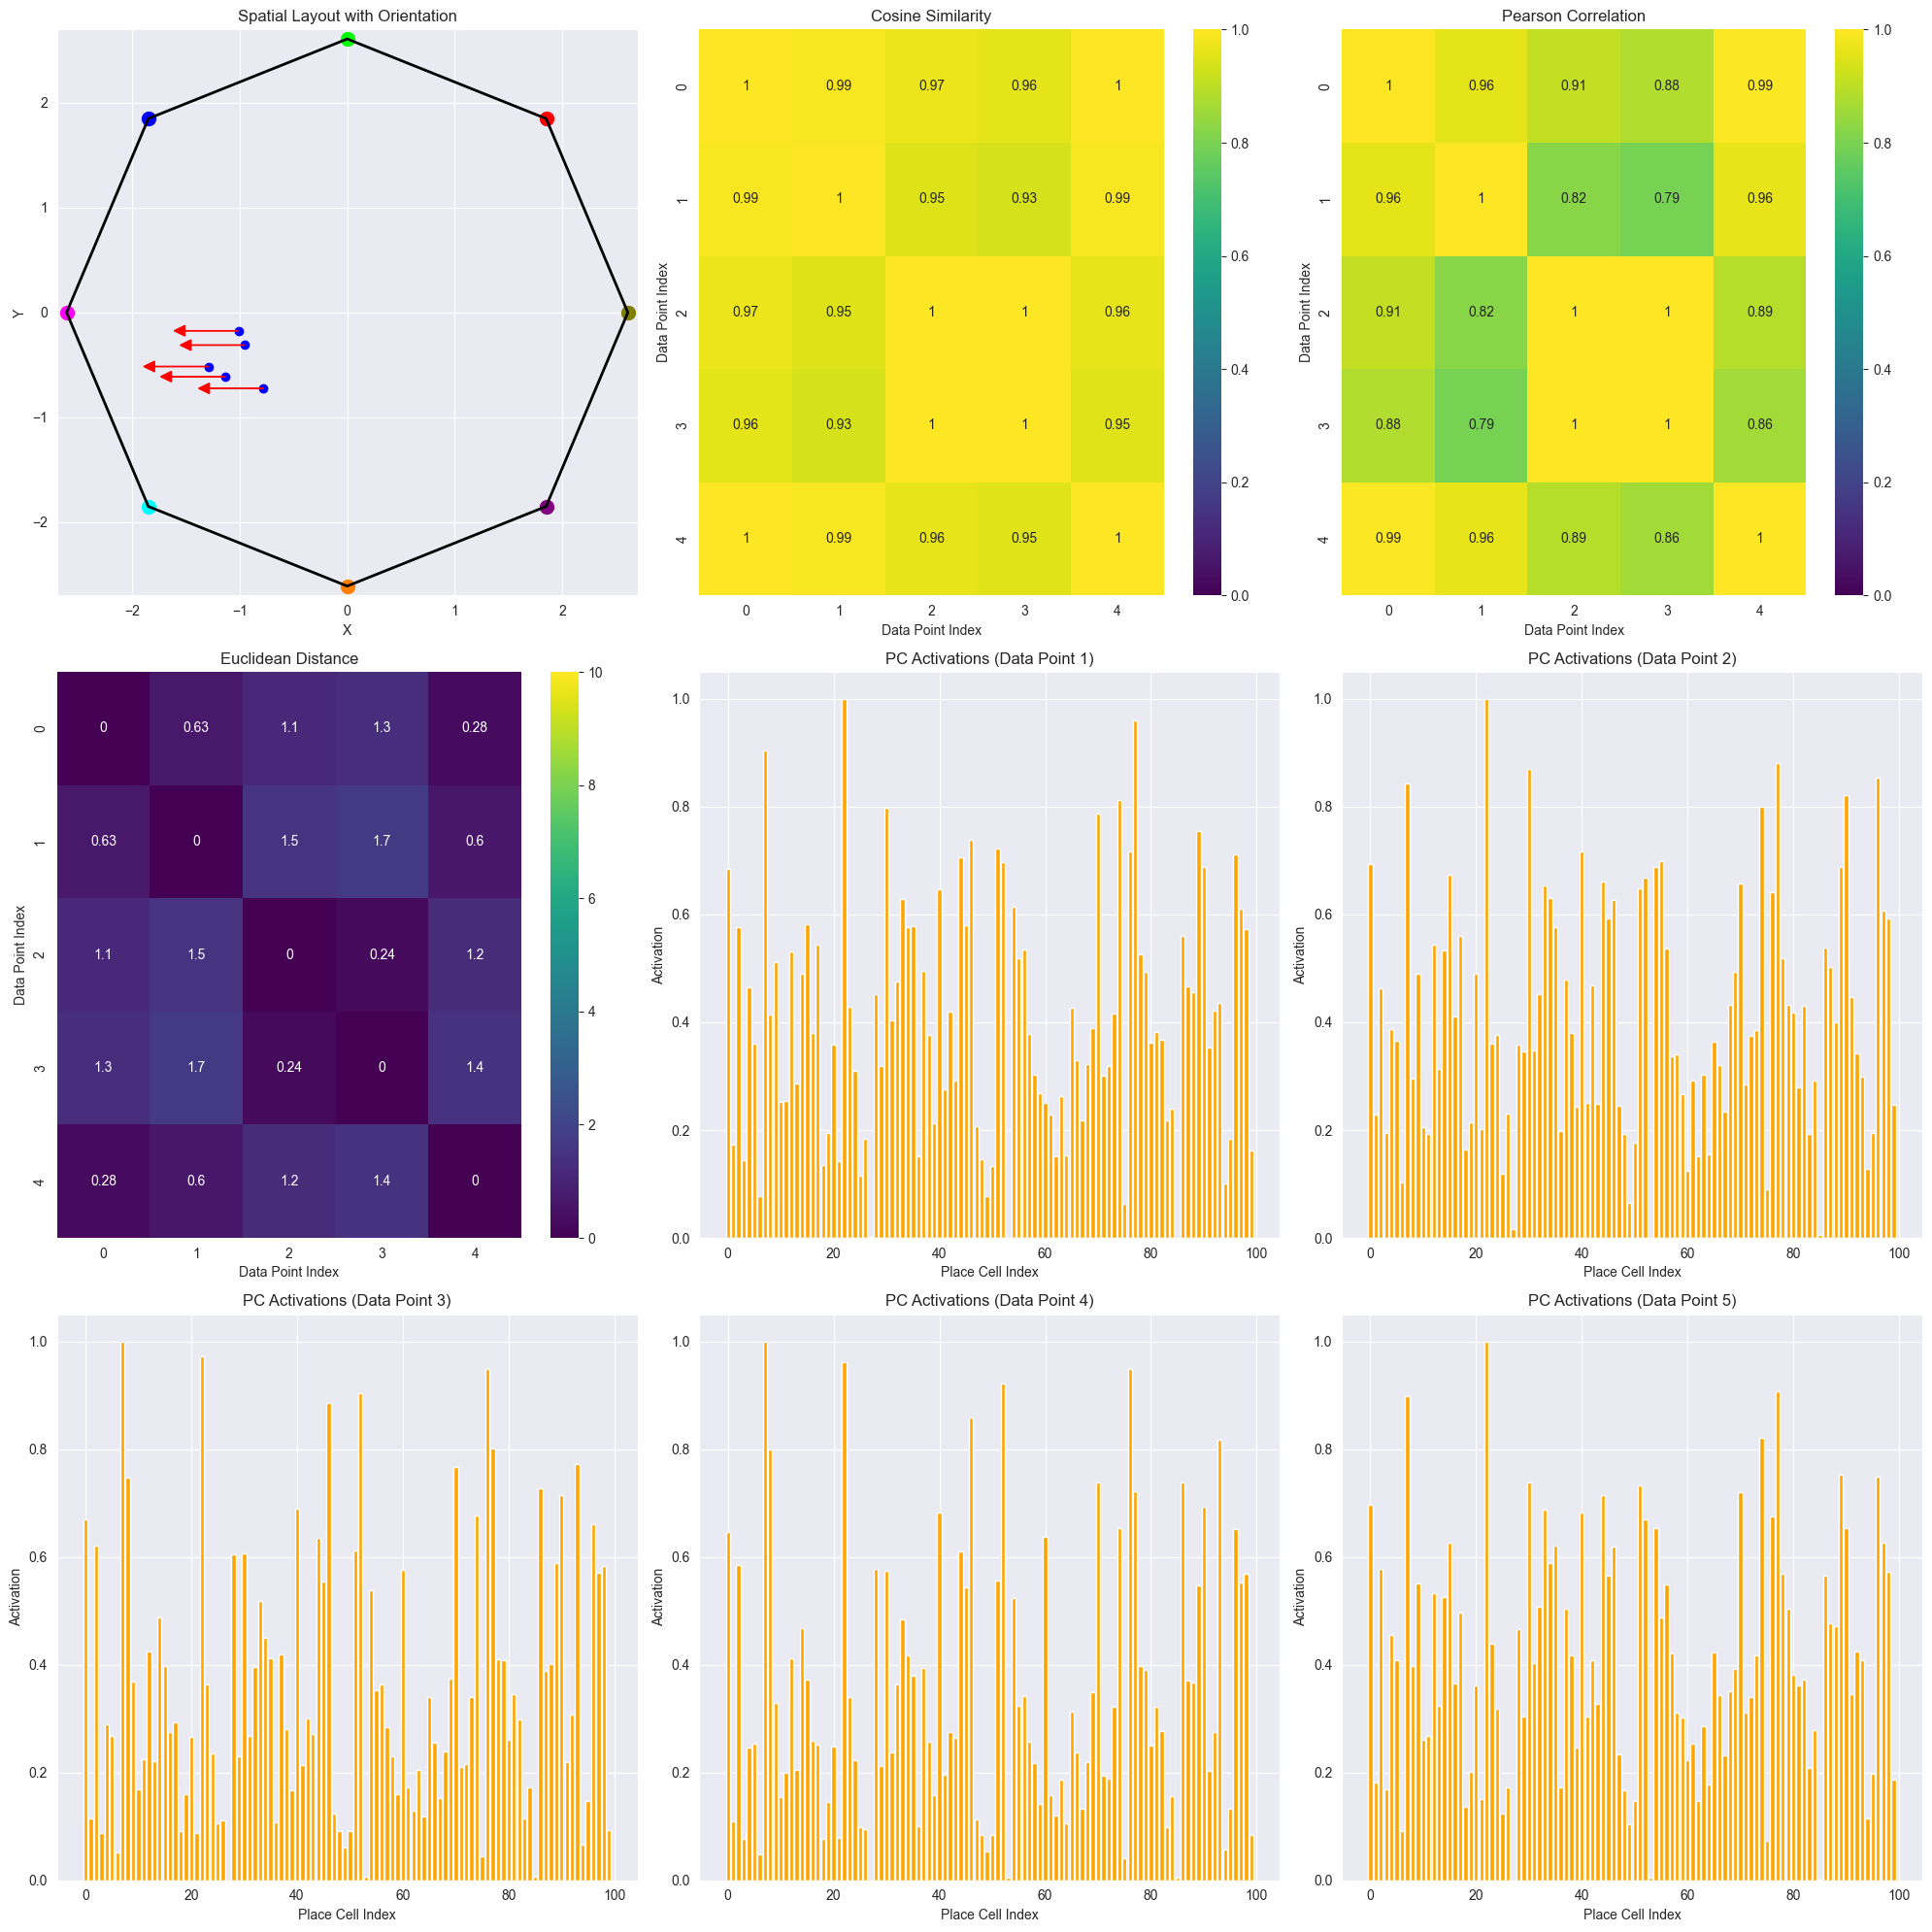

In [22]:
modes = ['nearest_same_orientation','nearest_different_orientation', 'farthest_same_orientation', 'farthest_different_orientation']             
test = select_knn_with_orientation(grouped_data, 180, 5,mode=modes[0])
calculate_and_visualize_similarity(test,pc_network,feature_type='multimodal',landmarks=landmarks)

In [23]:
def calculate_and_visualize_grouped_similarity(grouped_data_points, pc_network, feature_type='multimodal', landmarks=None, walls=None):
    """
    Calculate and visualize similarity metrics for grouped data points.
    Each row corresponds to one group and displays:
    - Spatial Plot
    - Cosine Similarity Matrix
    - Pearson Correlation Matrix
    - Euclidean Distance Matrix

    Parameters:
    - grouped_data_points: list of lists of data points.
    - pc_network: object, the place cell network used to get activations.
    - feature_type: str, the feature type used to calculate activations ('cnn' or 'multimodal').
    - landmarks: list of tuples [(x, y, (r, g, b))], coordinates and colors of landmarks.
    - walls: list of tuples [((x1, y1), (x2, y2))], coordinates of walls.

    Returns:
    - None, but displays the combined visualization.
    """
    num_groups = len(grouped_data_points)
    num_cols = 4
    num_rows = num_groups

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.suptitle("Similarity Metrics for Grouped Data Points", fontsize=16)

    for row, data_points in enumerate(grouped_data_points):
        if not data_points:
            continue
        
        # Step 1: Spatial Plot
        ax = axes[row, 0]
        x_coords = [dp.x for dp in data_points]
        y_coords = [dp.y for dp in data_points]
        thetas = [dp.theta for dp in data_points]

        # Plot data points and orientation vectors
        ax.scatter(x_coords, y_coords, c='blue', label='Data Points', zorder=15)
        for x, y, theta in zip(x_coords, y_coords, thetas):
            dx = 0.3 * np.cos(theta)
            dy = 0.3 * np.sin(theta)
            ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red', zorder=20)

        # Plot landmarks
        # Build the octagon using landmark positions if provided
        if landmarks is not None:
            landmark_positions = [(x, y) for (x, y, _) in landmarks]
    
            # Sort landmarks based on their angle from the origin to create an ordered octagon
            landmark_positions.sort(key=lambda p: np.arctan2(p[1], p[0]))
            octagon_vertices = np.array(landmark_positions + [landmark_positions[0]])  # Close the octagon
    
            # Plot the octagon
            ax.plot(octagon_vertices[:, 0], octagon_vertices[:, 1], color='black', linewidth=2)
    
            # Plot landmarks
            for (x, y, (r, g, b)) in landmarks:
                ax.scatter(x, y, color=(r, g, b), s=100)

        # Plot walls
        if walls is not None:
            for (start, end) in walls:
                ax.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=2)

        ax.set_xlim([-2.9, 2.9])
        ax.set_ylim([-2.9, 2.9])
        ax.set_title(f'Group {row + 1} - Spatial Plot')

        # Step 2: Calculate Similarity Metrics
        activation_vectors = [
            pc_network.get_all_pc_activations_normalized(dp.multimodal_feature_vector, norm_type='min_max')
            for dp in data_points
        ]
        activation_vectors = np.array(activation_vectors)

        # Cosine similarity matrix
        cosine_sim_matrix = 1 - squareform(pdist(activation_vectors, metric='cosine'))
        # Euclidean distance matrix
        euclidean_dist_matrix = squareform(pdist(activation_vectors, metric='euclidean'))
        n = len(pc_network.pc_list)
        euclidean_scale = np.sqrt(n)

        # Pearson correlation matrix
        pearson_corr_matrix = np.zeros((len(activation_vectors), len(activation_vectors)))
        for i in range(len(activation_vectors)):
            for j in range(len(activation_vectors)):
                if i != j:
                    pearson_corr_matrix[i, j], _ = pearsonr(activation_vectors[i], activation_vectors[j])
                else:
                    pearson_corr_matrix[i, j] = 1

        # Step 3: Cosine Similarity Heatmap
        ax = axes[row, 1]
        sns.heatmap(cosine_sim_matrix, ax=ax, cmap='viridis', annot=True, fmt='.2f', vmin=0, vmax=1, cbar=True)
        ax.set_title('Cosine Similarity')
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Data Point Index')

        # Step 4: Pearson Correlation Heatmap
        ax = axes[row, 2]
        sns.heatmap(pearson_corr_matrix, ax=ax, cmap='viridis', annot=True, fmt='.2f', vmin=0, vmax=1, cbar=True)
        ax.set_title('Pearson Correlation')
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Data Point Index')

        # Step 5: Euclidean Distance Heatmap
        ax = axes[row, 3]
        sns.heatmap(euclidean_dist_matrix, ax=ax, cmap='viridis', annot=True, fmt='.2f', vmin=0, vmax=euclidean_scale, cbar=True)
        ax.set_title('Euclidean Distance')
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Data Point Index')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [24]:
gdata = [select_knn_with_orientation(grouped_data, 180, 5,mode=modes[0]),select_knn_with_orientation(grouped_data, 180, 5,mode=modes[1]),select_knn_with_orientation(grouped_data, 180, 5,mode=modes[2]),select_knn_with_orientation(grouped_data, 180, 5,mode=modes[3])]

# Make Place Cell activation Videos

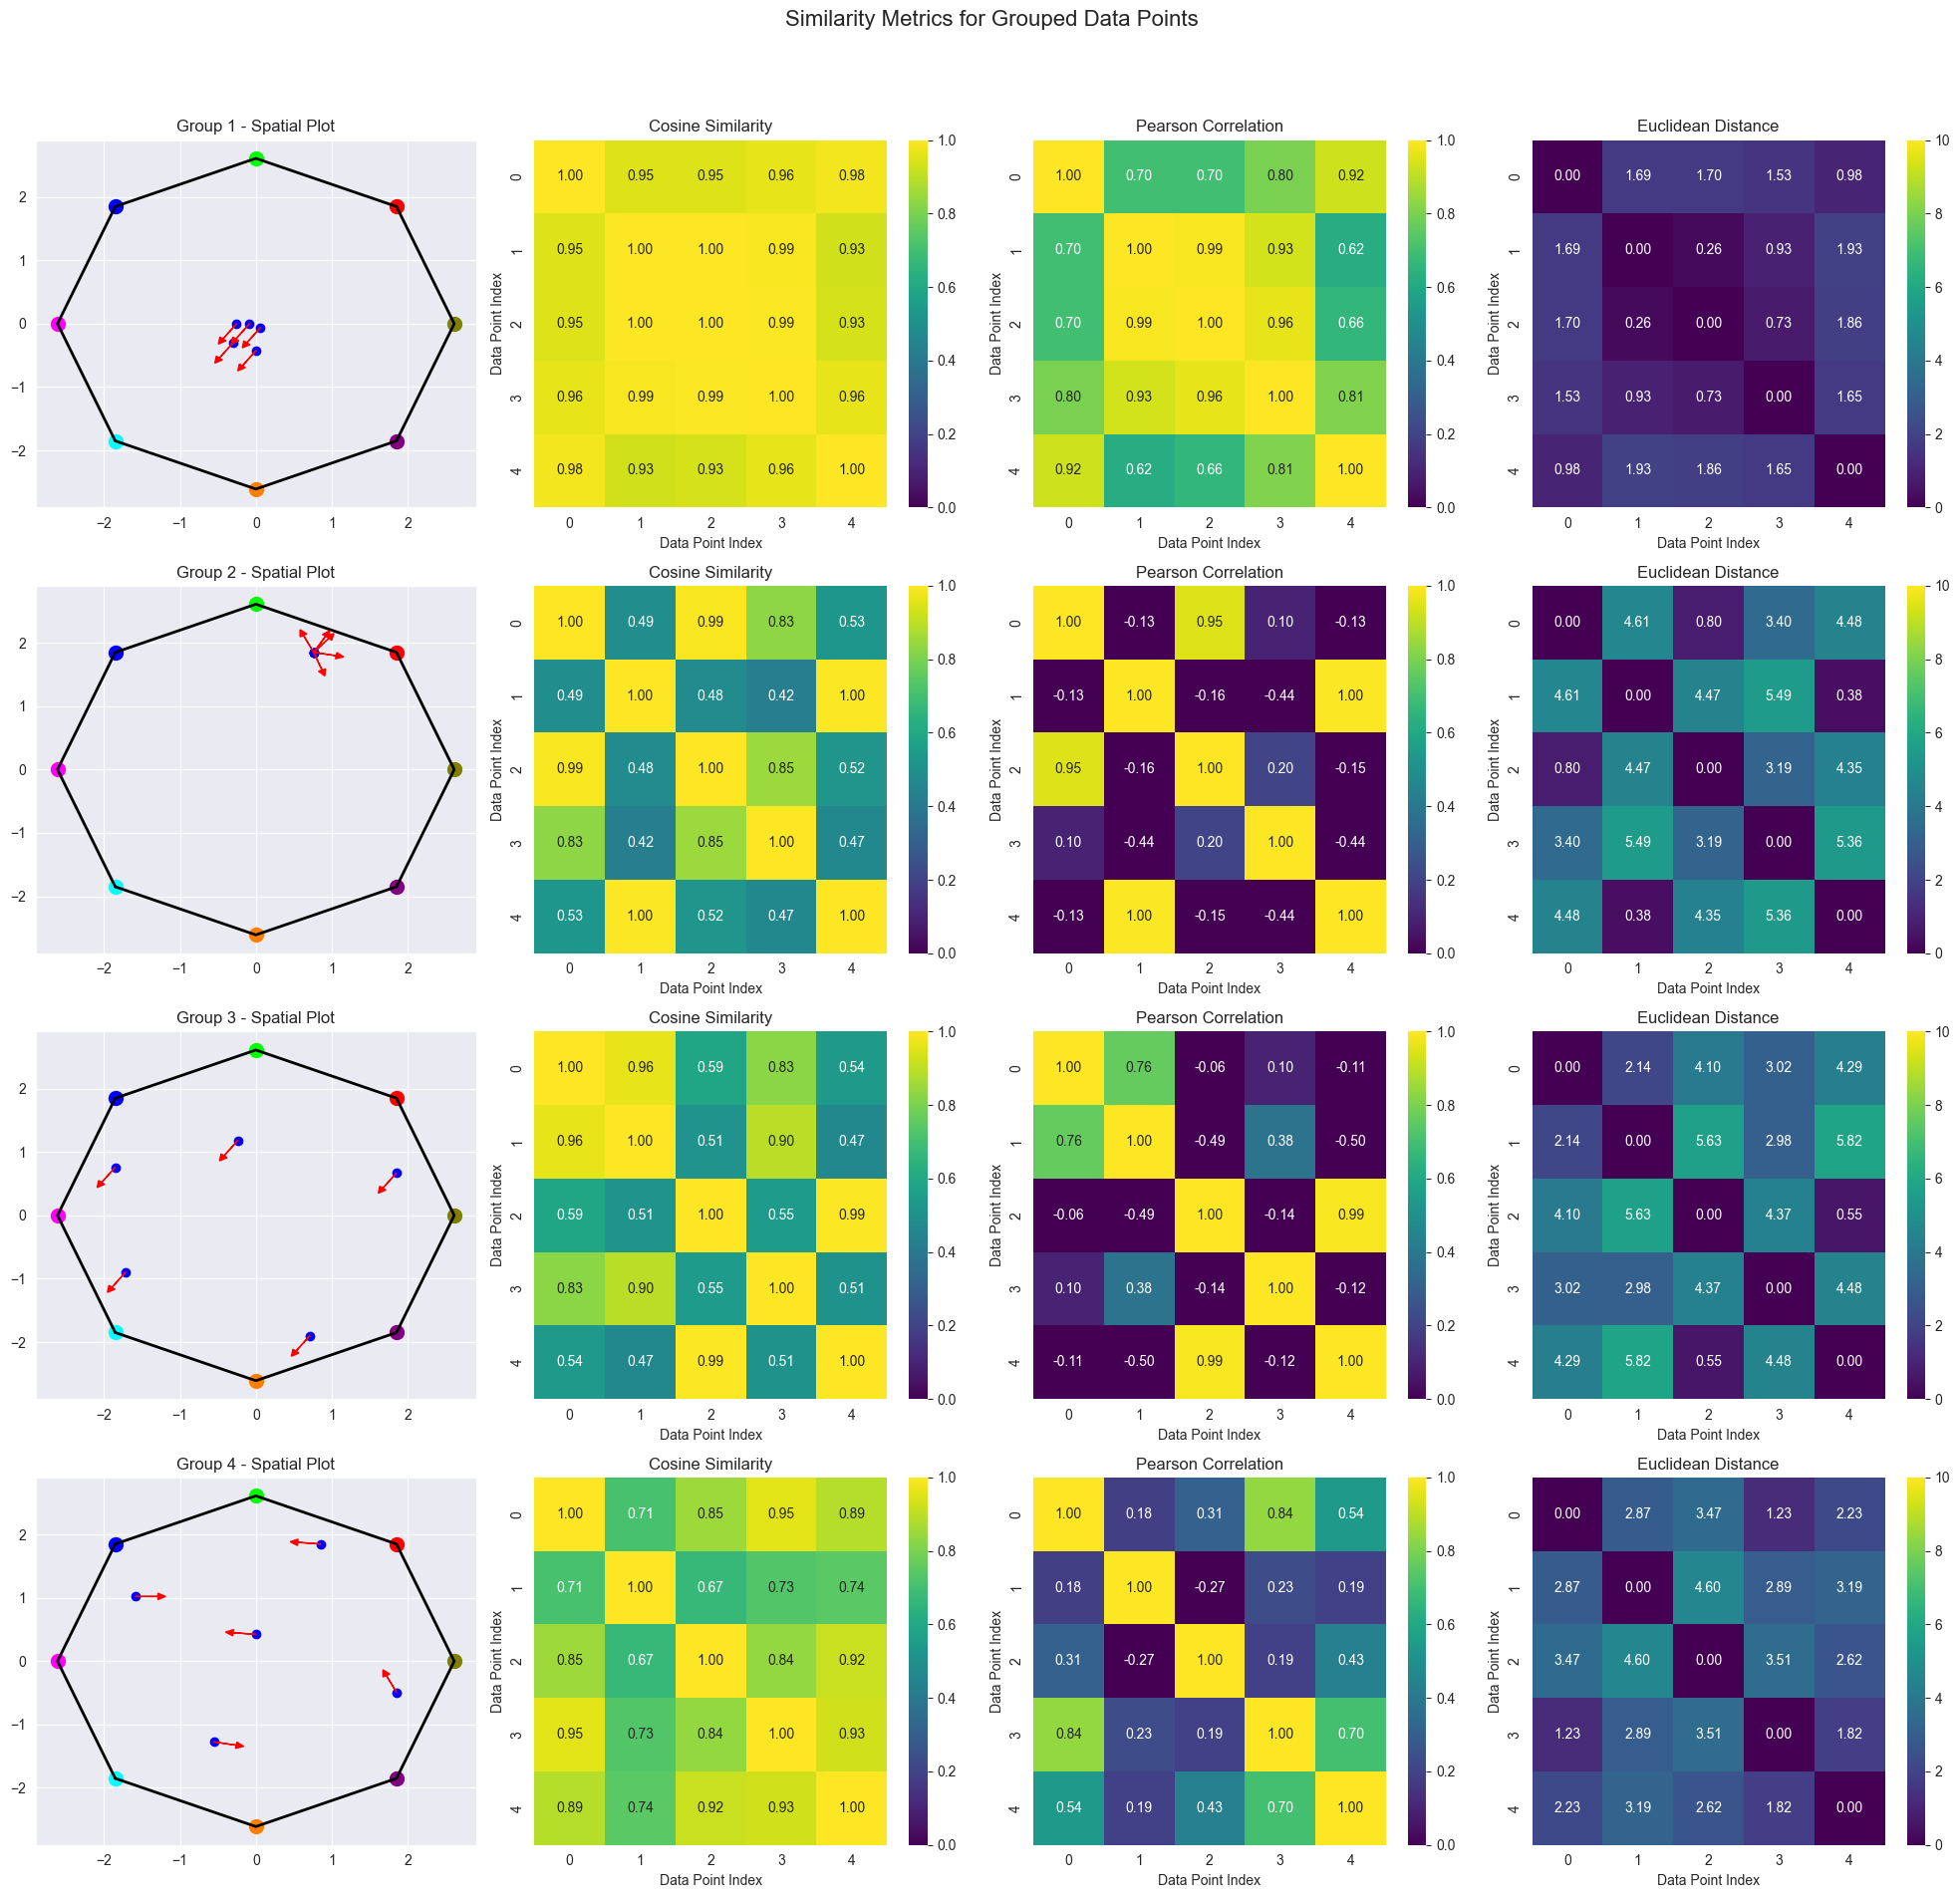

In [25]:
calculate_and_visualize_grouped_similarity(gdata, pc_network, landmarks=landmarks)

In [71]:
def plot_place_cell_activity_by_point(data_point,feature_type = "cnn"):
    """
    Plot the x, y location of the data point and the corresponding place cell activations.
    
    Args:
    - index (int): The index of the selected data point.
    """
    # Get the x, y location of the selected data point
    x = data_point.x
    y = data_point.y
    dx = 0.45 * np.cos(data_point.theta)
    dy = 0.45 * np.sin(data_point.theta)
    
    
    # Get the place cell activations for the selected data point
    if feature_type == "cnn":
        activations = pc_network.get_all_pc_activations_normalized(data_point.cnn_feature_vector)
    else:
        activations = pc_network.get_all_pc_activations_normalized(data_point.multimodal_feature_vector)

    # Create two subplots: one for x, y location and one for place cell activations
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the x, y location on the first subplot
    ax[0].quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].scatter(x, y, color='blue', s=50, zorder=5)
    ax[0].set_xlim(-3.5, 3.5)
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].set_title(f"x, y Location of Data Point")
    ax[0].set_xlabel("X Coordinate")
    ax[0].set_ylabel("Y Coordinate")

    # Plot the place cell activations on the second subplot
    ax[1].bar(range(len(pc_network.pc_list)), activations, color='red')
    ax[1].set_title(f"Place Cell Activations for Data Point")
    ax[1].set_xlabel("Place Cell")
    ax[1].set_xticks(range(len(pc_network.pc_list)))
    ax[1].set_xticklabels(range(len(pc_network.pc_list)))
    # ax[1].set_ylim(0, 1)
    ax[1].set_ylabel("Activation Level")
    
    # Show the plots
    plt.show()

In [ ]:
def create_animation_from_group(grouped_data, mask, feature_type = "cnn", filename="output_animation.mp4", fps=2):
    """
    Create an animation from plots of data points belonging to the same landmark mask.

    Args:
    - grouped_data: dict, output from `group_dataset_by_landmark_mask`.
    - mask: tuple, the landmark mask to create the animation for.
    - filename: str, the name of the output video file.
    - fps: int, frames per second for the animation.
    """
    if mask not in grouped_data:
        print(f"Mask {mask} not found in grouped data.")
        return

    # Extract the data points for the given mask
    data_points = grouped_data[mask]

    # Set up the figure and subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Initialize the plots (empty)
    quiver = ax[0].quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=1, color='r')  # Initialize with 0
    dot = ax[0].scatter(0, 0, color='blue', s=50, zorder=5)  # Initialize with 0
    bar = ax[1].bar([], [])

    # Set initial titles, labels, and limits
    ax[0].set_xlim(-3.5, 3.5)
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].set_title("x, y Location of Data Point")
    ax[0].set_xlabel("X Coordinate")
    ax[0].set_ylabel("Y Coordinate")

    ax[1].set_title("Place Cell Activations for Data Point")
    ax[1].set_xlabel("Place Cell")
    ax[1].set_ylabel("Activation Level")

    # Animation update function
    def update(frame):
        data_point = data_points[frame]
        
        # Update quiver and scatter for x, y location
        x, y, theta = data_point.x, data_point.y, data_point.theta
        dx, dy = 0.45 * np.cos(math.radians(theta)), 0.45 * np.sin(math.radians(theta))
        quiver.set_UVC(dx, dy)
        quiver.set_offsets([[x, y]])
        dot.set_offsets([[x, y]])

        # Update bar plot for place cell activations
        if feature_type == "cnn":
            activations = pc_network.get_all_pc_activations_normalized(data_point.cnn_feature_vector)
        else: 
            activations = pc_network.get_all_pc_activations_normalized(data_point.multimodal_feature_vector)
        ax[1].clear()  # Clear and redraw bars
        ax[1].bar(range(len(activations)), activations, color='red')
        ax[1].set_title("Place Cell Activations for Data Point")
        ax[1].set_xlabel("Place Cell")
        ax[1].set_ylabel("Activation Level")

        return quiver, dot, ax[1]

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(data_points), blit=False)

    # Save the animation to a video file
    ani.save(filename, fps=fps, writer="ffmpeg")
    print(f"Animation saved as {filename}")

In [16]:
def create_animation_from_spatial_group(grouped_data, pc_network, theta, feature_type="cnn", filename="output_animation.mp4", fps=2):
    """
    Create an animation from plots of data points belonging to the same theta group and its spatial clusters.

    Args:
    - grouped_data: dict, output from `group_dataset_by_theta_and_spatial_proximity`.
    - pc_network: object, the place cell network used to get activations.
    - theta: the theta value to access the first key pair.
    - feature_type: str, type of feature vector ("cnn" or other).
    - filename: str, the name of the output video file.
    - fps: int, frames per second for the animation.
    """
    if theta not in grouped_data:
        print(f"Theta {theta} not found in grouped data.")
        return

    # Extract the spatial clusters for the given theta
    spatial_clusters = grouped_data[theta]

    # Flatten all data points from all spatial clusters into a single list
    data_points = [dp for cluster in spatial_clusters.values() for dp in cluster]

    # Set up the figure and subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Initialize the plots (empty)
    quiver = ax[0].quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=1, color='r')  # Initialize with 0
    dot = ax[0].scatter(0, 0, color='blue', s=50, zorder=5)  # Initialize with 0
    bar = ax[1].bar([], [])

    # Set initial titles, labels, and limits
    ax[0].set_xlim(-3.5, 3.5)
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].set_title("x, y Location of Data Point")
    ax[0].set_xlabel("X Coordinate")
    ax[0].set_ylabel("Y Coordinate")

    ax[1].set_title("Place Cell Activations for Data Point")
    ax[1].set_xlabel("Place Cell")
    ax[1].set_ylabel("Activation Level")

    # Animation update function
    def update(frame):
        data_point = data_points[frame]
        
        # Update quiver and scatter for x, y location
        x, y, theta = data_point.x, data_point.y, data_point.theta
        dx, dy = 0.45 * np.cos(math.radians(theta)), 0.45 * np.sin(math.radians(theta))
        quiver.set_UVC(dx, dy)
        quiver.set_offsets([[x, y]])
        dot.set_offsets([[x, y]])

        # Update bar plot for place cell activations
        if feature_type == "cnn":
            activations = pc_network.get_all_pc_activations_normalized(data_point.cnn_feature_vector)
        else: 
            activations = pc_network.get_all_pc_activations_normalized(data_point.multimodal_feature_vector)
        ax[1].clear()  # Clear and redraw bars
        ax[1].bar(range(len(activations)), activations, color='red')
        ax[1].set_title(f"Place Cell Activations for Data Point at (x={x:.2f}, y={y:.2f})")
        ax[1].set_xlabel("Place Cell")
        ax[1].set_ylabel("Activation Level")

        return quiver, dot, ax[1]

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(data_points), blit=False)

    # Save the animation to a video file
    ani.save(filename, fps=fps, writer="ffmpeg")
    print(f"Animation saved as {filename}")

In [ ]:
for key in spatial_grouped:
    filename="data/videos/place_cell_multi_"+str(key)+".mp4"
    create_animation_from_spatial_group(spatial_grouped, pc_network, key, feature_type="multimodal", filename=filename, fps=2)

In [ ]:
for mask, data_points in grouped.items():
    filename="data/videos/place_cell_multi_"+str(mask)+".mp4"
    create_animation_from_group(grouped, mask, feature_type = "multimodal", filename=filename, fps=2)